In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import subprocess
import scipy

from pathlib import Path
from scipy.io import loadmat, savemat

In [2]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [4]:
import subprocess

# Define your MATLAB function's arguments
N = 2**7 + 1  # Example value; adjust as needed
dt = 1e-4  # Example value; adjust as needed
T_end = 1  # Example value; adjust as needed
# mus = np.linspace(0.01, 0.02, 2)
mus = [0.05]
Mp = 10
K = T_end / dt
DS = 1
p = 2

In [5]:
if len(mus) == 1:
    mu_start = mus[0]
    mu_end = mus[0]
    mu_step = 0
else:
    mu_start = mus[0]
    mu_end = mus[-1]
    mu_step = mus[1] - mus[0]

In [39]:
import json

datapath = '/data1/jy384/research/Data/UnimodalSROB/Burgers/'
srcpath = '/home/jy384/projects/UnimodalSROB/examples/burgers/'

config = {
    "N": 2**7 + 1,
    "dt": 1e-4,
    "T_end": 1,
    "mus": list(mus),
    "Mp": Mp,
    "K": 1 / 1e-4,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQIPC",
        "modeltime": "continuous",
        "dt": 1e-4,
        "ddt_order": "2ex",
        "p": p, # polynomial order
        "lambda1": 0.0,
        "lambda2": 0.1,
        "lambda3": 640,
    },
    "type": "single"
}

config_path = Path(srcpath) / 'configs'/ f'config_mu_{mu_start}_{mu_step}_{mu_end}.json'
with open(config_path, 'w') as f:
    json.dump(config, f)


In [22]:
# Proper command to call your MATLAB function
matlab_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/burgers-helpers'); "
    f"runburgers({N}, {dt}, {T_end}, [{mus}], {Mp}, {DS}, '{config_path}'); exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_cmd, shell=True, check=True)

MATLAB is selecting SOFTWARE OPENGL rendering.
Running Burgers equation data generation
Parameters:
N = 129
dt = 0.0001
T_end = 1
mus = 0.05
Mp = 10
DS = 1
mu = 0.05
       99980           1



CompletedProcess(args='matlab -batch "addpath(\'/home/jy384/projects/UnimodalSROB/examples/burgers/burgers-helpers\'); runburgers(129, 0.0001, 1, [[0.05]], 10, 1, \'/home/jy384/projects/UnimodalSROB/examples/burgers/configs/config_mu_0.05_0_0.05.json\'); exit;"', returncode=0)

In [23]:
trajectories_path = Path(datapath) / 'trajectories'
snapshots_path = Path(datapath) / 'snapshots'
snapshotsDerivatives_path = Path(datapath) / 'snapshotsDerivatives'

# Find the files 
U_all_files = list(Path(datapath).rglob(f'U_all_mu_*'))
X_all_files = list(Path(datapath).rglob(f'X_all_mu_*'))
R_all_files = list(Path(datapath).rglob(f'R_all_mu_*'))

# Load the data with the mu_start, mu_end, and mu_step in their names
if U_all_files:
    for file in U_all_files:
        if str(mu_start) + '_' in file.name and str(mu_end) in file.name and str(mu_step) + '_' in file.name:
            print(file)
            U_all = loadmat(file)['U_all']
if X_all_files:
    for file in X_all_files:
        if str(mu_start) + '_' in file.name and str(mu_end) in file.name and str(mu_step) + '_' in file.name:
            print(file)
            X_all = loadmat(file)['X_all']
if R_all_files:
    for file in R_all_files:
        if str(mu_start) + '_' in file.name and str(mu_end) in file.name and str(mu_step) + '_' in file.name:
            print(file)
            R_all = loadmat(file)['R_all']

/data1/jy384/research/Data/UnimodalSROB/Burgers/trajectories/U_all_mu_0.05_0_0.05.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshots/X_all_mu_0.05_0_0.05.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshotsDerivatives/R_all_mu_0.05_0_0.05.mat


In [24]:
# Convert cell arrays to numpy arrays for X_all and R_all
X_all = np.array([X_all[0][i] for i in range(X_all.shape[1])])
R_all = np.array([R_all[0][i] for i in range(R_all.shape[1])])

print(U_all.shape, X_all.shape, R_all.shape)

(99980, 1) (1, 129, 99980) (1, 129, 99980)


# Alternating minimization to get V and Vbar

Reminder: `X` here is the snapshot matrix, `R` is the derivative matrix, `U_all` is the trajectories (i.e the domain of the function), `V` is the basis of the function, and `Vbar` is th next `q` basis functions.

In [25]:
X_all.shape

(1, 129, 99980)

## Find `r` first from relative error analysis

S =  [976.55227537 193.50600417  77.32098615  47.75696222  20.07273744]
idx =  6
rel_err_SVD[idx] =  8.395669247818205e-06


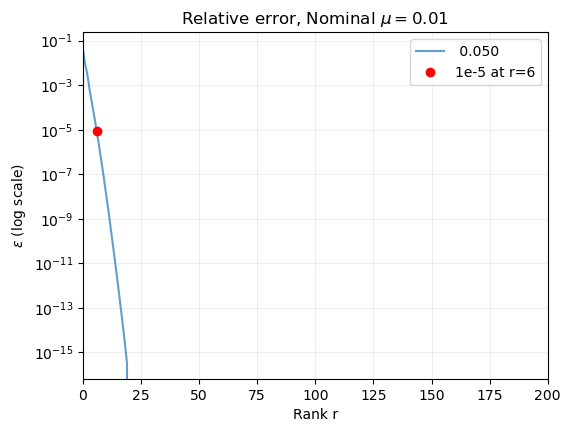

In [26]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'{mu: .3f}' for mu in mus]

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 1e-5

# mus = [0.01] # only one mu for now

for i in range(len(mus)):
    # svd
    U, S, V = np.linalg.svd(X_all[i, :, :], full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (K*Mp-1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"1e-5 at r={idx}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal $\mu = 0.01$")
    ax.legend()

In [27]:
# Model parameters
# p = 2          # degree of polynomial embeddings
# r = np.min(idx_lst)           # number of basis vectors in Vr
# q = np.max(idx_lst) - r           # number of basis vectors in Vbar

r = 7
q = 20

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.01       # regularization parameter
max_iter = 100  # maximum number of iterations

In [28]:
print("r = ", r)
print("q = ", q)

r =  7
q =  20


In [29]:
# Vr_lst = []
# Vbar_lst = []
# Shat_lst = []
# Xi_lst = []
# Poly_lst = []
# names = [f'{mu}' for mu in mus]
# sref_mean = []

# IC = np.zeros(N)

# for i in range(len(mus)):
#     # Procustes problem for each mu
#     S = X_all[i]
#     num_snapshots = S.shape[1]
#     # sref = np.mean(S, axis=1)
#     sref = IC
#     Sref = np.array([sref,] * num_snapshots).T
    
    
#     Shat, energy, Xi, Vr, Vbar, Poly = alternating_minimization(S, Sref, num_snapshots, max_iter, 1e-3, gamma, r, q, p)
    
    
#     Gamma_MAM = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
#     print(f"\nReconstruction error: {relative_error(S, Gamma_MAM, Sref):.4%}")
    
#     Vr_lst.append(Vr)
#     Vbar_lst.append(Vbar)
#     Shat_lst.append(Shat)
#     Xi_lst.append(Xi)
#     Poly_lst.append(Poly)
#     sref_mean.append(sref)

In [30]:
Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []
sref_mean = []
names = [f'{mu}' for mu in mus]

IC = np.zeros(N)

for i in range(len(mus)):
    # Procustes problem for each mu
    S = X_all[i, :, :]
    num_snapshots = S.shape[1]
    
    # sref = []
    # for j in range(Mp):
    #     start_ind = int(j * S.shape[1]/Mp)
    #     end_ind = int((j+1)*S.shape[1]/Mp)
    #     sref.append(np.mean(S[:, start_ind:end_ind], axis=1))
        
    # sref = np.mean(np.array(sref), axis=0)
    
    # sref = np.mean(S, axis=1)
    sref = IC
    # use sref = 0
    # sref = 0
    Sref = np.array([sref,] * num_snapshots).T
    
    
    U, _, _ = np.linalg.svd((S-Sref), full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    Shat = Vr.T @ (S-Sref)
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    # Gamma_MPOD = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
    Gamma_MPOD = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(S, Gamma_MPOD, Sref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(Shat)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)
    sref_mean.append(sref)


Reconstruction error: 0.2847%


In [31]:
np.allclose(np.concatenate(polynomial_form(Shat, p=p), axis=0), Poly)

True

In [32]:
from scipy.io import savemat
# Save the data
ROBsNL_path = Path(datapath) / 'ROBsNL'

Vr_arr = np.array(Vr_lst)
Vbar_arr = np.array(Vbar_lst)
Shat_arr = np.array(Shat_lst)
Xi_arr = np.array(Xi_lst)
Poly_arr = np.array(Poly_lst)
sref_mean_arr = np.array(sref_mean)

print(sref_mean_arr.shape)

Vr_arr = np.transpose(Vr_arr, (1, 2, 0))
Vbar_arr = np.transpose(Vbar_arr, (1, 2, 0))
Shat_arr = np.transpose(Shat_arr, (1, 2, 0))
Xi_arr = np.transpose(Xi_arr, (1, 2, 0))
Poly_arr = np.transpose(Poly_arr, (1, 2, 0))
sref_mean_arr = np.transpose(sref_mean_arr, (1, 0))


savemat(f'{ROBsNL_path}/Vr_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Vr_all': Vr_arr})
savemat(f'{ROBsNL_path}/Vbar_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Vbar_all': Vbar_arr})
savemat(f'{ROBsNL_path}/Shat_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Shat_all': Shat_arr})
savemat(f'{ROBsNL_path}/Xi_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Xi_all': Xi_arr})
savemat(f'{ROBsNL_path}/Poly_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Poly_all': Poly_arr})
savemat(f'{ROBsNL_path}/s_ref_mean_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'s_ref_mean_all': sref_mean_arr})


(1, 129)


In [33]:
np.concatenate(polynomial_form(Shat, p=3), axis=0).shape

(14, 99980)

# Matlab routine for OpInf

In [54]:
# params.modelform = 'LQI';           % model is linear-quadratic with input term
# params.modeltime = 'continuous';    % learn time-continuous model
# params.dt        = dt;              % timestep to compute state time deriv
# params.ddt_order = '1ex';           % explicit 1st order timestep scheme

# % Inputs:
# %   - params: parameters for the operator inference, including:
# %       - modelform: model form of the operator
# %       - modeltime: model time of the operator
# %       - dt: timestep to compute state time derivative
# %       - ddt_order: explicit 1st order timestep scheme
# %   - mus: parameter values
# %   - r: POD basis order
# %   - X_all: state data
# %   - R_all: RHS data (residual)
# %   - U_all: input data
# %   - Vr_all: truncated POD basis

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

config_path = Path(srcpath) / 'configs'/ f'config_mu_{mu_start}_{mu_step}_{mu_end}.json'
with open(config_path, 'w') as f:
    json.dump(config, f)


matlab_opinf_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/'); "
    f"run_burgersOpInf_NL('{config_path}'); exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_opinf_cmd, shell=True, check=True)

MATLAB is selecting SOFTWARE OPENGL rendering.
mu_start: 0.05
mu_end: 0.05
mu_step: 0
Loading s_ref_all from 
s_ref_all_mu_0.05_0_0.05.mat
   129     7

   129    20

           7       99980

           7       99980

Size of Shat after cat
           7       99960

Size of dShatdt
       99960           7

size of ind
           1       99960

drp: 
    77

Obtained data matrix...
Size of A

ans =

       99960         114

Size of b

ans =

       99960           7

Size of Aplus
      100074         114

Condition number of Aplus
   1.6580e+05

Size of bplus
      100074           7

Condition number of bplus
   4.5343e+03

Solving...
Solved!
Operators are inferred.
Type of operators:
struct
Operator inference done
Solving for mu = 0.05
Size of X
         129       99980

Bhat is not empty
Size of Ahat
     7     7

Size pf Fhat
     7    28

Size of Bhat
     7     1

Size pf Phat
     7    77

Size of s_hat
           7       10001

Hello
s_rec_all_mu_0.05_0_0.05.mat
Saving recon

CompletedProcess(args='matlab -batch "addpath(\'/home/jy384/projects/UnimodalSROB/examples/burgers/\'); run_burgersOpInf_NL(\'/home/jy384/projects/UnimodalSROB/examples/burgers/configs/config_mu_0.05_0_0.05.json\'); exit;"', returncode=0)

In [55]:
# load s_ref_mean.txt file
s_ref_mean = np.loadtxt('./s_ref_mean.txt')
print(s_ref_mean)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
# Read s_ref_all.mat and s_rec_all.mat
s_ref_all = loadmat(f'{datapath}referenceState/s_ref_all_mu_{mu_start}_{mu_step}_{mu_end}.mat')['s_ref_all']
s_rec_all = loadmat(f'{datapath}reconstructedState/s_rec_all_mu_{mu_start}_{mu_step}_{mu_end}.mat')['s_rec_all']

# extract the tensors from the cell arrays
s_ref_all = np.array([s_ref_all[i][0] for i in range(s_ref_all.shape[0])])
s_rec_all = np.array([s_rec_all[i][0] for i in range(s_rec_all.shape[0])])

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


/tmp/ipykernel_3975423/4231087462.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


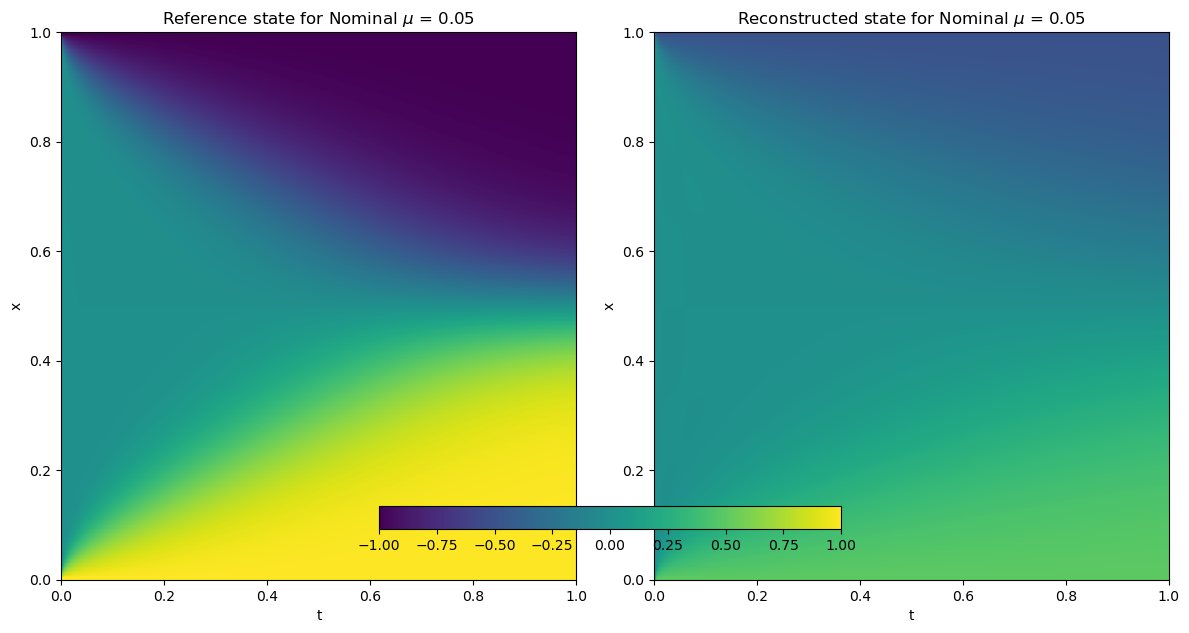

In [57]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(len(mus)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
    print("X = ", X.shape)
    print("Y = ", Y.shape)
    print("s_ref_all[i] = ", s_ref_all[i].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(s_ref_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for Nominal $\mu$ = {mus[i]}')
    
    c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Reconstructed state for Nominal $\mu$ = {mus[i]}')  
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(s_ref_all[i]), np.min(s_rec_all[i])])
    vmax = np.max([np.max(s_ref_all[i]), np.max(s_rec_all[i])])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()